## India Flight Price Prediction

In [1]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
import math

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (10,5)

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
# Loading the dataset

flight_data = pd.read_excel(r"Data_Train.xlsx")
flight_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


##### There are 10 independent features, we have to predict "Price". There are 10683 data samples available to us in which there is one missing value in "Total_stops" and "Route"

#### Handling the missing values

In [5]:
flight_data["Total_Stops"].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [6]:
flight_data[flight_data.isna().any(axis=1)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [7]:
flight_data[(flight_data["Source"] == "Delhi") & (flight_data["Destination"] == "Cochin") & (flight_data["Airline"] == "Air India" ) \
            & (flight_data["Dep_Time"] == "09:45") & (flight_data["Duration"] == "23h 40m") & (flight_data["Price"] == 7480) ]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
1616,Air India,24/05/2019,Delhi,Cochin,DEL → MAA → COK,09:45,09:25 25 May,23h 40m,1 stop,No info,7480
2554,Air India,15/05/2019,Delhi,Cochin,DEL → MAA → COK,09:45,09:25 16 May,23h 40m,1 stop,No info,7480
4351,Air India,27/06/2019,Delhi,Cochin,DEL → MAA → COK,09:45,09:25 28 Jun,23h 40m,1 stop,No info,7480
7896,Air India,12/06/2019,Delhi,Cochin,DEL → MAA → COK,09:45,09:25 13 Jun,23h 40m,1 stop,No info,7480
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [8]:
flight_data["Route"].fillna("DEL → MAA → COK", inplace = True)
flight_data["Total_Stops"].fillna("1 stop", inplace = True)

In [9]:
flight_data[flight_data.isna().any(axis=1)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price


#### Exploratory Data Analysis

In [10]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10683 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10683 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [11]:
flight_data["Date_of_Journey"].astype("str")

0        24/03/2019
1         1/05/2019
2         9/06/2019
3        12/05/2019
4        01/03/2019
            ...    
10678     9/04/2019
10679    27/04/2019
10680    27/04/2019
10681    01/03/2019
10682     9/05/2019
Name: Date_of_Journey, Length: 10683, dtype: object

In [12]:
# Extracting the time values
flight_data["Journey_Day"] = pd.to_datetime(flight_data["Date_of_Journey"], format = '%d/%m/%Y').dt.day
flight_data["Journey_Month"] = pd.to_datetime(flight_data["Date_of_Journey"], format = '%d/%m/%Y').dt.month
flight_data["Dep_Hour"] = pd.to_datetime(flight_data["Dep_Time"]).dt.hour
flight_data["Dep_Minute"] = pd.to_datetime(flight_data["Dep_Time"]).dt.minute
flight_data["Arrival_Hour"] = pd.to_datetime(flight_data["Arrival_Time"]).dt.hour
flight_data["Arrival_Minute"] = pd.to_datetime(flight_data["Arrival_Time"]).dt.minute

In [13]:
# Dropping the features
flight_data.drop(["Date_of_Journey", "Dep_Time", "Arrival_Time"], axis = 1, inplace = True)

In [14]:
flight_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [15]:
def fcnExtractDurationHour(x):
    try:
        hour = int(str.split(x, "h")[0])
        return hour
    except:
        return 0

def fcnExtractDurationMinute(x):
    try:
        lstDuration = str.split(x, " ")
        if len(lstDuration) == 0:
            minute = str.split(x, "m")
            if len(minute) == 0:
                return 0
            else:
                return int(minute[0])            
        else:
            minute = str.split(lstDuration[1], "m")
            return int(minute[0])
    except:
        return 0

In [16]:
#Extracting the Duration Hour and Minute
flight_data["Duration_Hour"] = flight_data["Duration"].apply(fcnExtractDurationHour)
flight_data["Duration_Minute"] = flight_data["Duration"].apply(fcnExtractDurationMinute)

In [17]:
# Dropping the feature
flight_data.drop(["Duration"], axis = 1, inplace = True)

#### Handling Categorical Data

In [18]:
flight_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_Hour,Duration_Minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


In [19]:
flight_data["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

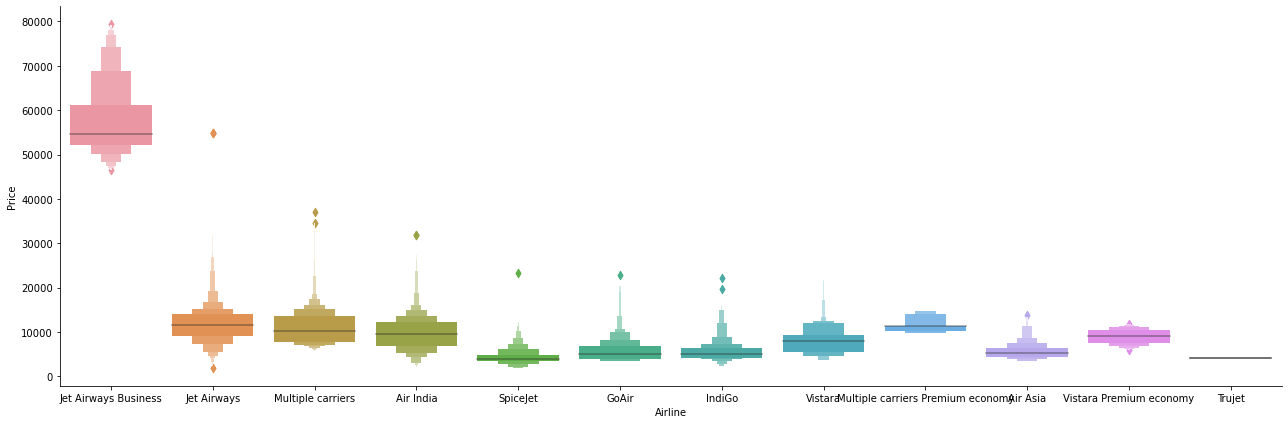

In [20]:
sns.catplot(y = "Price", x = "Airline", data = flight_data.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

##### From graph we can see that Jet Airways Business have the highest Price.
##### Apart from the first Airline almost all are having similar median

In [21]:
#Removing airlines with very less samples
airlines_to_remove = ["Multiple carriers Premium economy", "Jet Airways Business", "Vistara Premium economy", "Trujet"]
flight_data = flight_data[~flight_data["Airline"].isin(airlines_to_remove)].reset_index()
flight_data.drop(["index"], axis=1, inplace=True)

In [22]:
le1 = LabelEncoder()
airlines = le1.fit_transform(flight_data["Airline"])

In [23]:
ohe1 = OneHotEncoder()
airline_ohe = ohe1.fit_transform(airlines.reshape(-1,1))
airline_ohe = pd.DataFrame(airline_ohe.toarray(), columns = le1.classes_)

In [24]:
flight_data["Source"].value_counts()

Delhi       4522
Kolkata     2871
Banglore    2191
Mumbai       696
Chennai      380
Name: Source, dtype: int64

In [25]:
flight_data["Destination"].value_counts()

Cochin       4522
Banglore     2871
Delhi        1264
New Delhi     927
Hyderabad     696
Kolkata       380
Name: Destination, dtype: int64

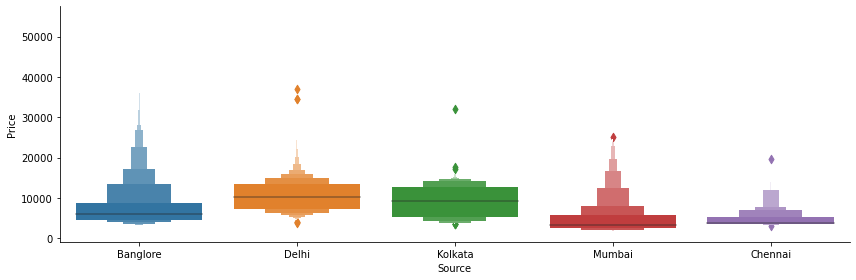

In [26]:
sns.catplot(y = "Price", x = "Source", data = flight_data.sort_values("Price", ascending = False), kind="boxen", height = 4, aspect = 3)
plt.show()

In [27]:
le2 = LabelEncoder()
source = le2.fit_transform(flight_data["Source"])
le3 = LabelEncoder()
destination = le3.fit_transform(flight_data["Destination"])

In [28]:
ohe2 = OneHotEncoder()
source_ohe = ohe2.fit_transform(source.reshape(-1,1))
source_ohe = pd.DataFrame(source_ohe.toarray(), columns = [x+"_s" for x in le2.classes_])

ohe3 = OneHotEncoder()
destination_ohe = ohe3.fit_transform(destination.reshape(-1,1))
destination_ohe = pd.DataFrame(destination_ohe.toarray(), columns = [x+"_d" for x in le3.classes_])

In [29]:
flight_data["Total_Stops"].value_counts()

1 stop      5608
non-stop    3488
2 stops     1518
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [30]:
flight_data["Additional_Info"].value_counts()

No info                         8325
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
No Info                            3
Business class                     1
2 Long layover                     1
1 Short layover                    1
Red-eye flight                     1
Name: Additional_Info, dtype: int64

In [31]:
flight_data.drop(labels = ["Additional_Info", "Route"], axis = 1, inplace = True)

In [32]:
total_stops = {"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}
flight_data["Total_Stops"].replace(to_replace = total_stops, inplace = True)

In [33]:
flight_data.shape

(10660, 13)

In [34]:
source_ohe.drop([source_ohe.columns[len(source_ohe.columns)-1]], axis=1, inplace = True)
destination_ohe.drop([destination_ohe.columns[len(destination_ohe.columns)-1]], axis=1, inplace = True)
airline_ohe.drop([airline_ohe.columns[len(airline_ohe.columns)-1]], axis=1, inplace = True)

#### Data Preparation

In [35]:
# Preparing the data for algorithms

X = pd.concat([airline_ohe, source_ohe, destination_ohe, flight_data[["Journey_Day", "Journey_Month", "Dep_Hour", 
                                                                            "Dep_Minute", "Arrival_Hour", "Arrival_Minute", "Duration_Hour", 
                                                                            "Duration_Minute", "Total_Stops"]]], axis = 1)
y = flight_data[["Price"]]

In [36]:
X.shape

(10660, 25)

#### Data Pipeline

In [37]:
#Loading the Test data
test_data = pd.read_excel(r"Test_set.xlsx")

In [38]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


In [39]:
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [40]:
airlines_to_remove = ["Multiple carriers Premium economy", "Jet Airways Business", "Vistara Premium economy", "Trujet"]
test_data = test_data[~test_data["Airline"].isin(airlines_to_remove)]


In [41]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attibute_names = attribute_names
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return X[self.attibute_names]

In [42]:
class CategoricalValuesHandling(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        le_1 = LabelEncoder()
        ohe_1 = OneHotEncoder()
        airlines = le_1.fit_transform(X["Airline"])
        airline_ohe = ohe_1.fit_transform(airlines.reshape(-1,1))
        airline_ohe = pd.DataFrame(airline_ohe.toarray(), columns = le_1.classes_)
        
        le_2 = LabelEncoder()
        ohe_2 = OneHotEncoder()
        source = le_2.fit_transform(X["Source"])
        source_ohe = ohe_2.fit_transform(source.reshape(-1,1))
        source_ohe = pd.DataFrame(source_ohe.toarray(), columns = [x+"_s" for x in le_2.classes_])

        le_3 = LabelEncoder()
        ohe_3 = OneHotEncoder()
        dest = le_3.fit_transform(X["Destination"])
        dest_ohe = ohe_3.fit_transform(dest.reshape(-1,1))
        dest_ohe = pd.DataFrame(dest_ohe.toarray(), columns = [x+"_d" for x in le_3.classes_])
        
        source_ohe.drop([source_ohe.columns[len(source_ohe.columns)-1]], axis=1, inplace = True)
        dest_ohe.drop([dest_ohe.columns[len(dest_ohe.columns)-1]], axis=1, inplace = True)
        airline_ohe.drop([airline_ohe.columns[len(airline_ohe.columns)-1]], axis=1, inplace = True)
        
        data = pd.concat([airline_ohe, source_ohe, dest_ohe], axis = 1)
        
        return data.values
    
class DateValuesHandling(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X["Journey_Day"] = pd.to_datetime(X["Date_of_Journey"], format = '%d/%m/%Y').dt.day
        X["Journey_Month"] = pd.to_datetime(X["Date_of_Journey"], format = '%d/%m/%Y').dt.month
        X["Dep_Hour"] = pd.to_datetime(X["Dep_Time"]).dt.hour
        X["Dep_Minute"] = pd.to_datetime(X["Dep_Time"]).dt.minute
        X["Arrival_Hour"] = pd.to_datetime(X["Arrival_Time"]).dt.hour
        X["Arrival_Minute"] = pd.to_datetime(X["Arrival_Time"]).dt.minute
        X["Duration_Hour"] = X["Duration"].apply(fcnExtractDurationHour)
        X["Duration_Minute"] = X["Duration"].apply(fcnExtractDurationMinute)
        
        X.drop(labels = ["Date_of_Journey", "Dep_Time", "Arrival_Time"], axis = 1, inplace = True)
        
        return X.values
    
class NumericValuesHandling(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        total_stops = {"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}
        X["Total_Stops"].replace(to_replace = total_stops, inplace = True)
        
        return X.values

In [43]:
cat_attribs = ["Airline", "Source", "Destination"]
date_attribs = ["Date_of_Journey", "Dep_Time", "Arrival_Time", "Duration"]
num_attribs = ["Total_Stops"]

In [44]:
# complete Pipeline

cat_pipeline = Pipeline([
    ("selector", DataFrameSelector(cat_attribs)),
    ("cat_handler", CategoricalValuesHandling())
])

date_pipeline = Pipeline([
    ("selector", DataFrameSelector(date_attribs)),
    ("date_handler", DateValuesHandling())    
])

num_pipeline = Pipeline([
    ("selector", DataFrameSelector(num_attribs)),
    ("num_handler", NumericValuesHandling())    
])

In [45]:
full_pipeline = FeatureUnion(transformer_list=[
    ("cat_features", cat_pipeline),
    ("date_features", date_pipeline),
    ("num_features", num_pipeline),
    
])

In [46]:
test_data_prepared = full_pipeline.fit_transform(test_data)

#### Feature Selection

In [47]:
X.head()

,Air Asia,Air India,GoAir,IndiGo,Jet Airways,Multiple carriers,SpiceJet,Banglore_s,Chennai_s,Delhi_s,Kolkata_s,Banglore_d,Cochin_d,Delhi_d,Hyderabad_d,Kolkata_d,Journey_Day,Journey_Month,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_Hour,Duration_Minute,Total_Stops
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24,3,22,20,1,10,2,50,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,5,5,50,13,15,7,25,2
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,9,6,9,25,4,25,19,0,2
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,12,5,18,5,23,30,5,25,1
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3,16,50,21,35,4,45,1


In [48]:
y.head()

,Price
0,3897
1,7662
2,13882
3,6218
4,13302


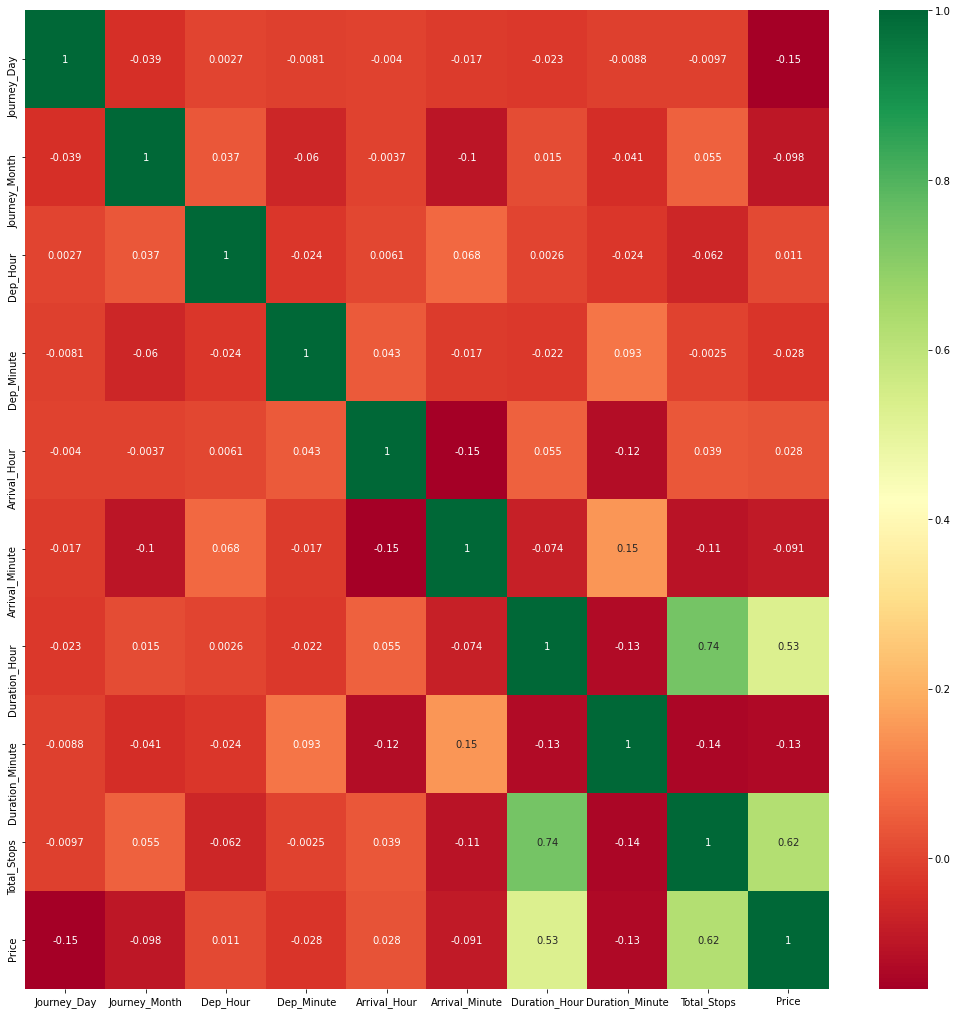

In [49]:
#Finding the correlation

plt.figure(figsize = (18,18))
sns.heatmap(pd.concat([X[["Journey_Day", "Journey_Month", "Dep_Hour", "Dep_Minute", "Arrival_Hour", "Arrival_Minute", "Duration_Hour", 
                          "Duration_Minute", "Total_Stops"]], y], axis = 1).corr(), annot = True, cmap = "RdYlGn")
plt.show()

In [50]:
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

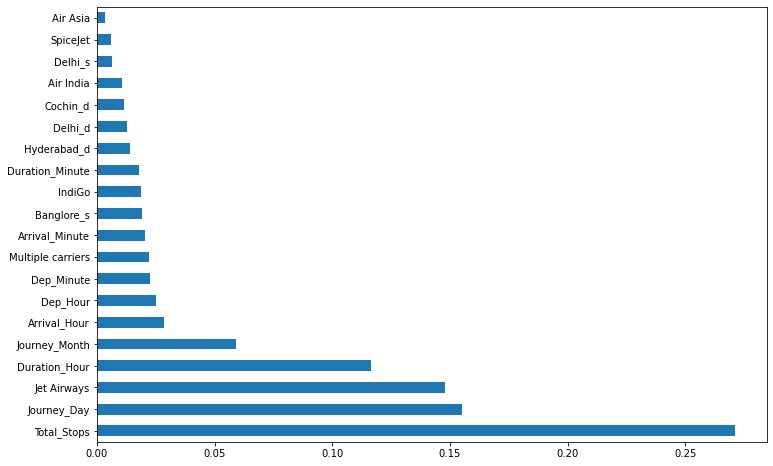

In [51]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

#### Model Fitting

In [52]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV, ShuffleSplit, RandomizedSearchCV

np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [53]:
def fcnPrintErrorMetrics(y_test, y_pred):
    print('R2:', metrics.r2_score(y_test, y_pred))
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print('MSE:', metrics.mean_squared_error(y_test, y_pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    sns.distplot(y_test - y_pred)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state = 42)

R2: 0.5963776394720987
MAE: 1944.0921443236248
MSE: 7994078.752286344
RMSE: 2827.3801923841697


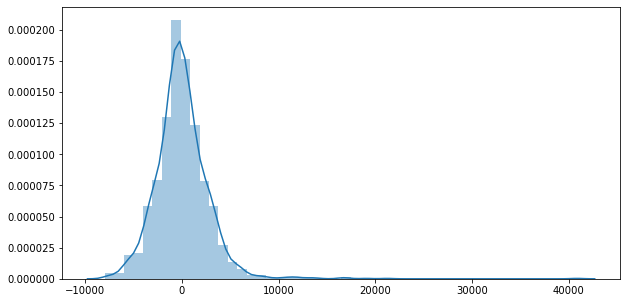

In [55]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

fcnPrintErrorMetrics(y_test, y_pred)

R2: 0.596336421333356
MAE: 1943.8909222256802
MSE: 7994895.112030886
RMSE: 2827.5245555133356


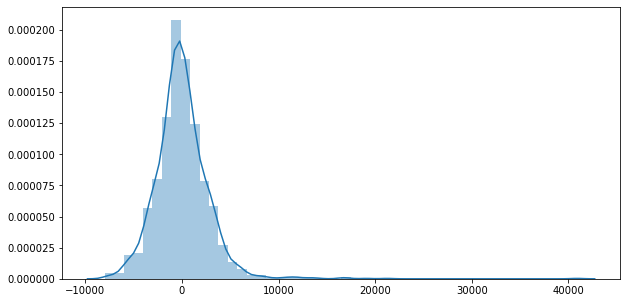

In [56]:
ridge = Ridge()
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train, y_train)
y_pred2 = ridge_regressor.predict(X_test)

fcnPrintErrorMetrics(y_test, y_pred2)

R2: 0.596336421333356
MAE: 1943.8909222256802
MSE: 7994895.112030886
RMSE: 2827.5245555133356


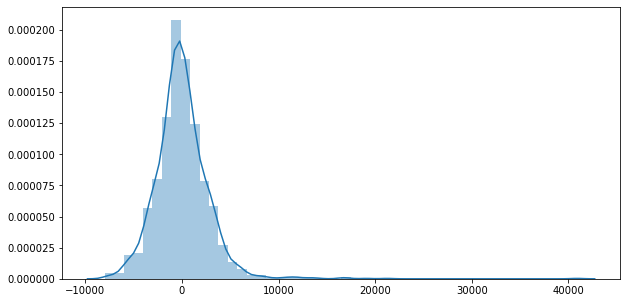

In [57]:
lasso = Lasso()
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train,y_train)
y_pred3 = ridge_regressor.predict(X_test)

fcnPrintErrorMetrics(y_test, y_pred3)

R2: 0.7061678863309191
MAE: 1385.6661585365853
MSE: 5819590.999738508
RMSE: 2412.382846842206


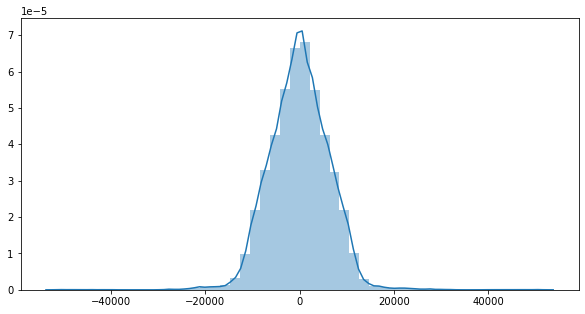

In [58]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)
dt_reg.score(X_test, y_test)
y_pred4 = dt_reg.predict(X_test)

fcnPrintErrorMetrics(y_test, y_pred4)

R2: 0.8188292274149035
MAE: 1170.6382691981905
MSE: 3588238.822456678
RMSE: 1894.2647181575962


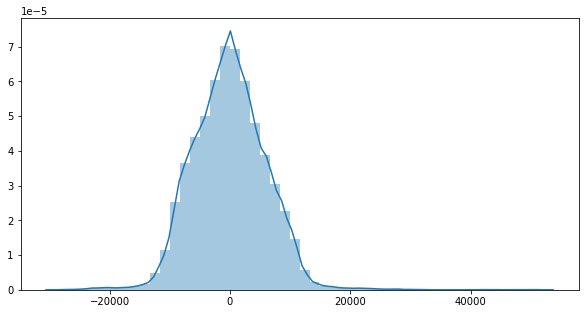

In [59]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
rf_reg.score(X_test, y_test)
y_pred5 = rf_reg.predict(X_test)

fcnPrintErrorMetrics(y_test, y_pred5)

R2: 0.23796831073409608
MAE: 3140.8741612074377
MSE: 15092675.558811925
RMSE: 3884.929286204824


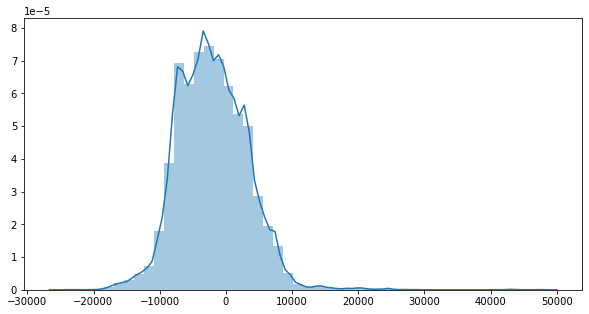

In [60]:
ab_reg = AdaBoostRegressor(loss = "exponential")
ab_reg.fit(X_train, y_train)
ab_reg.score(X_test, y_test)
y_pred6 = ab_reg.predict(X_test)

fcnPrintErrorMetrics(y_test, y_pred6)

R2: 0.7756645782508087
MAE: 1421.9147366414895
MSE: 4443150.835461296
RMSE: 2107.8782781416235


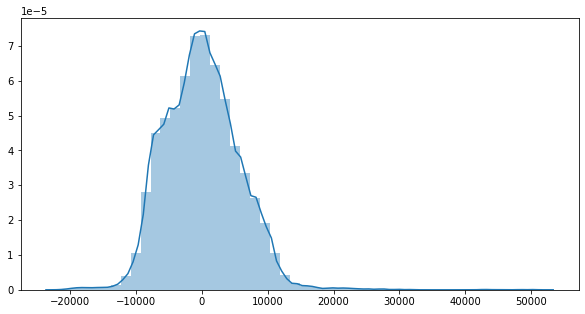

In [61]:
gb_reg = GradientBoostingRegressor(max_depth = 7, max_features = 4, n_estimators = 35)
gb_reg.fit(X_train, y_train)
gb_reg.score(X_test, y_test)
y_pred7 = gb_reg.predict(X_test)

fcnPrintErrorMetrics(y_test, y_pred7)

R2: 0.8400719722238028
MAE: 1144.251300461073
MSE: 3167508.4776488254
RMSE: 1779.7495547544956


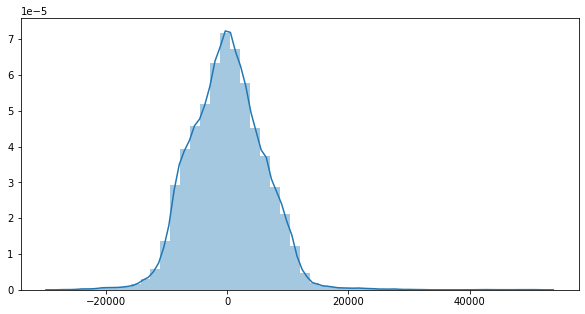

In [62]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_reg.score(X_test, y_test)
y_pred8 = xgb_reg.predict(X_test)

fcnPrintErrorMetrics(y_test, y_pred8)

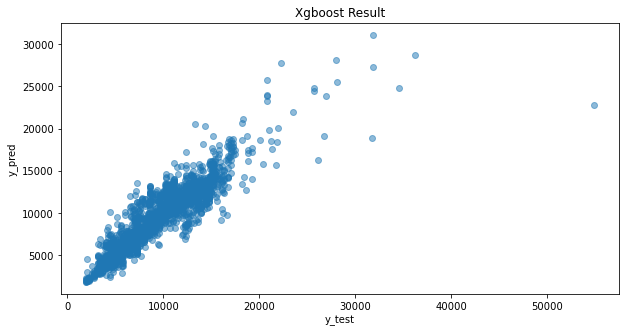

In [63]:
plt.scatter(y_test, y_pred8, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("Xgboost Result")
plt.show()

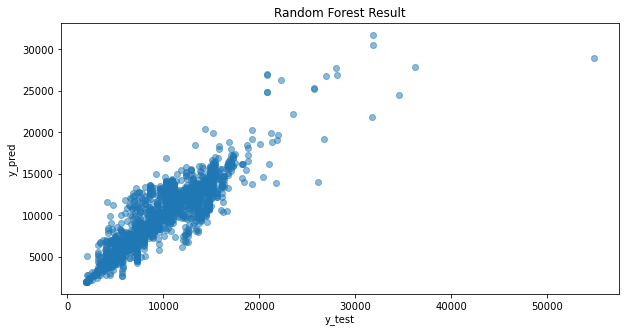

In [64]:
plt.scatter(y_test, y_pred5, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("Random Forest Result")
plt.show()

#### Hyperparameter Optimization

In [70]:
def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                "n_estimators" : [int(x) for x in np.linspace(start = 100, stop = 1000, num = 50)],
                "max_features" : ['auto', 'sqrt'],
                "max_depth" : [int(x) for x in np.linspace(5, 30, num = 6)],
                "min_samples_split" : [2, 5, 10, 15],
                "min_samples_leaf" : [1, 2, 5, 10]            
            }
        },
        'xgboost': {
            'model': XGBRegressor(),
            'params': {
                'n_estimators': [100, 200, 300],
                'reg_alpha':[0.005, 0.01, 0.05],
                'gamma':[i/10.0 for i in range(0,5)],
                'min_child_weight':[6,8,10,12],
                'max_depth':[4,5,6]
            }
        }

    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  RandomizedSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])


model_scores = find_best_model_using_gridsearchcv(X.values, y.values)
model_scores

,model,best_score,best_params
0,random_forest,0.826636,"{'n_estimators': 595, 'min_samples_split': 15,..."
1,xgboost,0.826514,"{'reg_alpha': 0.01, 'n_estimators': 100, 'min_..."


In [72]:
model_scores["best_params"][0]

{'n_estimators': 595,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 30}

R2: 0.899920650405973
MAE: 873.492450858657
MSE: 1987924.892077402
RMSE: 1409.9379036246248


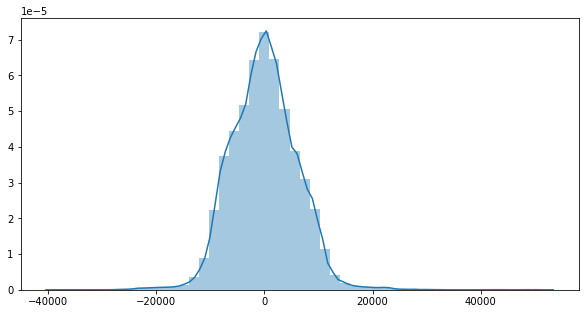

In [75]:
rf_reg_f = RandomForestRegressor(n_estimators= 595, min_samples_split = 15, min_samples_leaf = 1, max_features = 'auto', max_depth = 30)
rf_reg_f.fit(X.values, y.values)
y_prediction = rf_reg_f.predict(X.values)

fcnPrintErrorMetrics(y.values, y_prediction)

#### Saving the Model

In [66]:
import pickle
import json

In [76]:
with open('flight_price_predictor.pickle','wb') as f:
    pickle.dump(rf_reg_f, f)

In [78]:
cat_feature_columns = {
    "airlines" : [col for col in le1.classes_], 
    "source" : [col for col in le2.classes_],
    "destination" : [col for col in le3.classes_], 
    "wickets" : {"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, 
    "data_columns" : ['Air Asia', 'Air India', 'GoAir', 'IndiGo', 'Jet Airways',
       'Multiple carriers', 'SpiceJet', 'Banglore_s', 'Chennai_s', 'Delhi_s',
       'Kolkata_s', 'Banglore_d', 'Cochin_d', 'Delhi_d', 'Hyderabad_d',
       'Kolkata_d', 'Journey_Day', 'Journey_Month', 'Dep_Hour', 'Dep_Minute',
       'Arrival_Hour', 'Arrival_Minute', 'Duration_Hour', 'Duration_Minute',
       'Total_Stops']
}

with open("columns.json", "w") as f:
    f.write(json.dumps(cat_feature_columns))